# RUN

In [41]:
!nvidia-smi

Sun Oct 23 03:27:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    28W /  70W |   9016MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## IMPORT / FUNCTION

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
import cv2
import os
import zipfile
import glob as gb
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau , ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
from tensorflow.keras import layers


In [43]:
def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

In [44]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [45]:
IMAGE_SHAPE = (224,224)
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [46]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

## CODE

In [47]:
!ls pest

test  train


In [48]:
### extractiing and reading data
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/GEMASTIK/pest_img.zip','r')
zip_ref.extractall()
zip_ref.close()

In [49]:
### get to know the data :
for dirpath, dirname, filename in os.walk('pest'):
  print(f"There are {len(dirname)} directories and {len(filename)} image in '{dirpath}'.")

There are 2 directories and 0 image in 'pest'.
There are 9 directories and 0 image in 'pest/test'.
There are 0 directories and 50 image in 'pest/test/mosquito'.
There are 0 directories and 50 image in 'pest/test/sawfly'.
There are 0 directories and 50 image in 'pest/test/mites'.
There are 0 directories and 50 image in 'pest/test/beetle'.
There are 0 directories and 50 image in 'pest/test/bollworm'.
There are 0 directories and 50 image in 'pest/test/aphids'.
There are 0 directories and 50 image in 'pest/test/armyworm'.
There are 0 directories and 50 image in 'pest/test/grasshopper'.
There are 0 directories and 50 image in 'pest/test/stem_borer'.
There are 9 directories and 0 image in 'pest/train'.
There are 0 directories and 300 image in 'pest/train/mosquito'.
There are 0 directories and 300 image in 'pest/train/sawfly'.
There are 0 directories and 300 image in 'pest/train/mites'.
There are 0 directories and 300 image in 'pest/train/beetle'.
There are 0 directories and 300 image in 'pes

In [50]:
### SPLITTING DATA
tf.random.set_seed(42)

train_dir = 'pest/train'
test_dir = 'pest/test'


training=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.05
).flow_from_directory(train_dir,batch_size=16,target_size=(224,224),subset="training")

validing=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.05
).flow_from_directory(train_dir,batch_size=16,target_size=(224,224),subset='validation',shuffle=True)

testing=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
).flow_from_directory(test_dir,batch_size=16,target_size=(224,224),shuffle=True)

Found 2565 images belonging to 9 classes.
Found 135 images belonging to 9 classes.
Found 450 images belonging to 9 classes.


### EFNET

In [51]:
# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [54]:
efficientnet_model = create_model(efficientnet_url, num_classes=training.num_classes)

# Compile
efficientnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])
# Fit the model
efficientnet_history = efficientnet_model.fit(training,
                                  epochs=20,
                                  batch_size=16,
                                  steps_per_epoch=len(training)//16,
                                  validation_data=validing,
                                  validation_steps=len(validing)//4,
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="efficientnetB0")]) # name of log files


Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20221023-033001
Epoch 1/20
10/10 [==============================] - 10s 179ms/step - loss: 2.3237 - accuracy: 0.1000 - val_loss: 2.1094 - val_accuracy: 0.0625
Epoch 2/20
10/10 [==============================] - 1s 78ms/step - loss: 2.2786 - accuracy: 0.1625 - val_loss: 1.8974 - val_accuracy: 0.4375
Epoch 3/20
10/10 [==============================] - 1s 70ms/step - loss: 1.9650 - accuracy: 0.3313 - val_loss: 1.8156 - val_accuracy: 0.4062
Epoch 4/20
10/10 [==============================] - 1s 66ms/step - loss: 1.8423 - accuracy: 0.4187 - val_loss: 1.8569 - val_accuracy: 0.2188
Epoch 5/20
10/10 [==============================] - 1s 65ms/step - loss: 1.9846 - accuracy: 0.3625 - val_loss: 1.6096 - val_accuracy: 0.5625
Epoch 6/20
10/10 [==============================] - 1s 79ms/step - loss: 1.7268 - accuracy: 0.4750 - val_loss: 1.7071 - val_accuracy: 0.4375
Epoch 7/20
10/10 [==============================] - 1s 72ms/step - loss: 

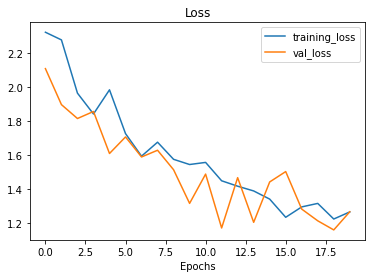

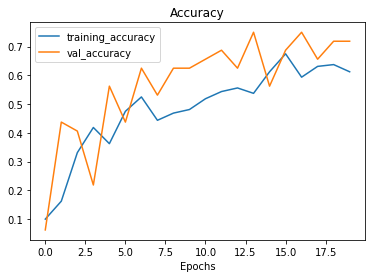

In [55]:
plot_loss_curves(efficientnet_history)

In [56]:
loss , acc = efficientnet_model.evaluate(testing)

29/29 [==============================] - 2s 50ms/step - loss: 1.2539 - accuracy: 0.6356


### Resnet

In [57]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

In [58]:
# Create model
resnet_model = create_model(resnet_url, num_classes=training.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])
# Fit the model
resnet_history = resnet_model.fit(training,
                                  epochs=20,
                                  steps_per_epoch=len(training)//16,
                                  validation_data=validing,
                                  validation_steps=len(validing)//4,
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20221023-033047
Epoch 1/20
10/10 [==============================] - 7s 146ms/step - loss: 4.0829 - accuracy: 0.1250 - val_loss: 2.5857 - val_accuracy: 0.1250
Epoch 2/20
10/10 [==============================] - 1s 83ms/step - loss: 2.7631 - accuracy: 0.1562 - val_loss: 2.6725 - val_accuracy: 0.3125
Epoch 3/20
10/10 [==============================] - 1s 77ms/step - loss: 2.5766 - accuracy: 0.2188 - val_loss: 2.2757 - val_accuracy: 0.2188
Epoch 4/20
10/10 [==============================] - 1s 81ms/step - loss: 2.5963 - accuracy: 0.1750 - val_loss: 2.3887 - val_accuracy: 0.1562
Epoch 5/20
10/10 [==============================] - 1s 70ms/step - loss: 2.6187 - accuracy: 0.2081 - val_loss: 2.1926 - val_accuracy: 0.1250
Epoch 6/20
10/10 [==============================] - 1s 78ms/step - loss: 2.5873 - accuracy: 0.2313 - val_loss: 2.1530 - val_accuracy: 0.2188
Epoch 7/20
10/10 [==============================] - 1s 77ms/step - loss: 2.433

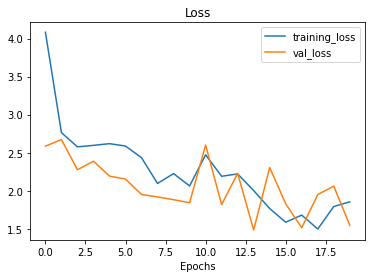

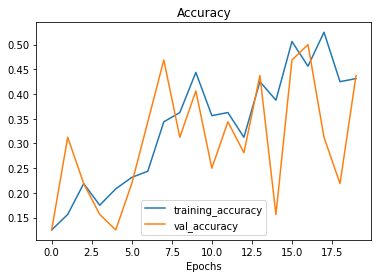

In [59]:
plot_loss_curves(resnet_history)

In [60]:
loss , acc = resnet_model.evaluate(testing)

29/29 [==============================] - 2s 54ms/step - loss: 1.3565 - accuracy: 0.5556


### Mobilenet

In [61]:
# Mobilenet V2 feature vector
mobilenet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

In [62]:
# Create model
mobilenet_model = create_model(mobilenet_url, num_classes=training.num_classes)

# Compile
mobilenet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])
# Fit the model
mobilenet_history = mobilenet_model.fit(training,
                                  epochs=20,
                                  steps_per_epoch=len(training)//16,
                                  validation_data=validing,
                                  validation_steps=len(validing)//4,
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="mobilenet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/mobilenet50V2/20221023-033130
Epoch 1/20
10/10 [==============================] - 5s 141ms/step - loss: 3.5185 - accuracy: 0.1813 - val_loss: 2.2697 - val_accuracy: 0.1562
Epoch 2/20
10/10 [==============================] - 1s 71ms/step - loss: 2.9099 - accuracy: 0.2000 - val_loss: 2.5492 - val_accuracy: 0.3125
Epoch 3/20
10/10 [==============================] - 1s 87ms/step - loss: 2.4280 - accuracy: 0.1875 - val_loss: 2.3584 - val_accuracy: 0.1875
Epoch 4/20
10/10 [==============================] - 1s 81ms/step - loss: 2.4559 - accuracy: 0.1813 - val_loss: 1.7251 - val_accuracy: 0.4062
Epoch 5/20
10/10 [==============================] - 1s 71ms/step - loss: 2.0464 - accuracy: 0.2812 - val_loss: 1.8810 - val_accuracy: 0.3750
Epoch 6/20
10/10 [==============================] - 1s 77ms/step - loss: 2.3202 - accuracy: 0.2812 - val_loss: 2.1647 - val_accuracy: 0.3438
Epoch 7/20
10/10 [==============================] - 1s 72ms/step - loss: 2.

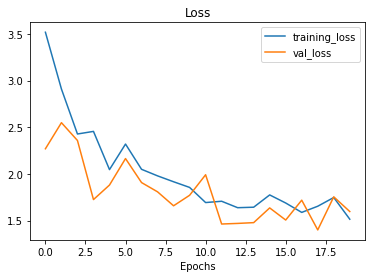

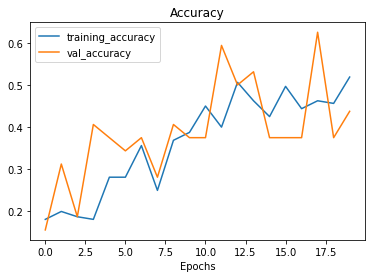

In [63]:
plot_loss_curves(mobilenet_history)

In [64]:
loss , acc = mobilenet_model.evaluate(testing)

29/29 [==============================] - 2s 56ms/step - loss: 1.6508 - accuracy: 0.4778
